# Importing functions and libs

In [1]:
from autoencoder import SimpleDecoder, SimpleEncoder, SimpleConvAutoencoder, ConvolutionalAutoencoder
from dataset import ImageDataset, TestDataset
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import os
import random

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Loading and transforming data

In [3]:
transform = {
    "train": transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize(mean=0, std=1),
     ]),
    "valid": transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0, std=1),
     ])
}

root_dir = "dataset/train"
image_paths = os.listdir(root_dir)
random.shuffle(image_paths)

images = ImageDataset(root_dir, image_paths, transform=transform["train"])
train_images = ImageDataset(root_dir, image_paths[:9000], transform=transform["train"])
valid_images = ImageDataset(root_dir, image_paths[9000:], transform=transform["valid"])
proliv_images = ImageDataset("dataset/proliv", transform=transform["valid"])

batch_size = 64

# Create DataLoader
images_loader = DataLoader(dataset=images, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(dataset=train_images, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_images, batch_size=batch_size, shuffle=True)
proliv_loader = DataLoader(dataset=proliv_images, batch_size=batch_size, shuffle=True)

# Training autoencoder

In [4]:
# encoder = SimpleEncoder()
# decoder = SimpleDecoder()
# model = SimpleConvAutoencoder(encoder, decoder)

model = ConvolutionalAutoencoder()

In [5]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003)
loss_fcn = nn.MSELoss()

In [6]:
best_valid_loss = float("+Inf")
best_epoch_num = None
validation_losses = []
train_losses = []

for epoch in range(60):
    print(f"Epoch {epoch}")
    model.train()
    train_loss = 0
    
    for images in train_loader:
        outputs = model(images)
        loss = loss_fcn(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss = train_loss / len(train_loader)
    model.eval()
    valid_loss = 0
    
    for images in valid_loader:
        outputs = model(images)
        loss = loss_fcn(outputs, images)
        valid_loss += loss.item()
    
    valid_loss = valid_loss / len(valid_loader)
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        torch.save(model, "best_model.pt")
        best_valid_loss = valid_loss
        best_epoch_num = epoch + 1
        print("Updated!")
    
    print(f"Validation Loss: {valid_loss}")
    

Epoch 0
Updated!
Validation Loss: 0.007655895460629836
Epoch 1
Updated!
Validation Loss: 0.002331165538635105
Epoch 2
Updated!
Validation Loss: 0.001300146061112173
Epoch 3
Updated!
Validation Loss: 0.0009077143149625044
Epoch 4
Updated!
Validation Loss: 0.0007082663396431599
Epoch 5
Updated!
Validation Loss: 0.0005932564308750443
Epoch 6
Updated!
Validation Loss: 0.000519242061272962
Epoch 7
Updated!
Validation Loss: 0.00046516625116055366
Epoch 8
Updated!
Validation Loss: 0.0004264681447239127
Epoch 9
Updated!
Validation Loss: 0.0003820379097305704
Epoch 10
Updated!
Validation Loss: 0.0003776521461986704
Epoch 11
Updated!
Validation Loss: 0.0003339846352901077
Epoch 12
Updated!
Validation Loss: 0.00030692342625116
Epoch 13
Updated!
Validation Loss: 0.00029932479628769215
Epoch 14
Updated!
Validation Loss: 0.00027971697454631794
Epoch 15
Updated!
Validation Loss: 0.0002540766799938865
Epoch 16
Validation Loss: 0.0002625089473440312
Epoch 17
Updated!
Validation Loss: 0.0002432489745842

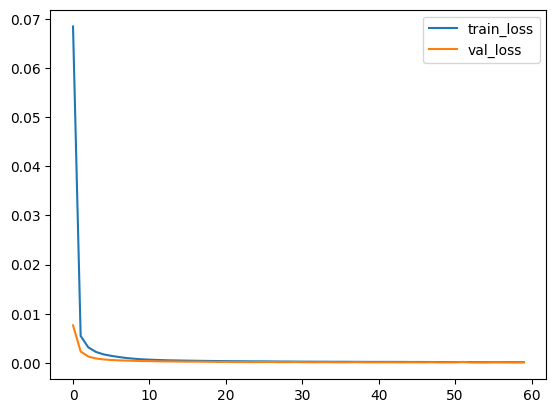

In [7]:
plt.plot(train_losses, label = 'train_loss')
plt.plot(validation_losses, label = 'val_loss')
plt.legend()

<Axes: >

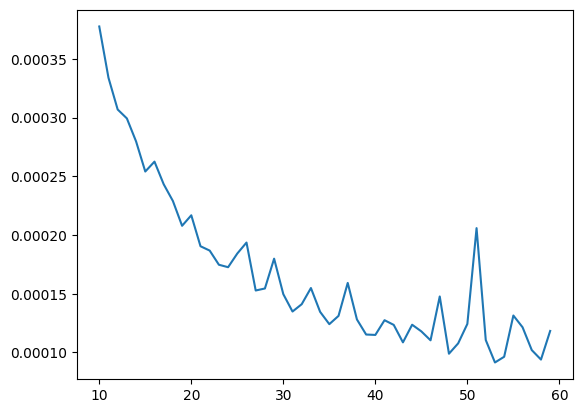

In [11]:
sns.lineplot(y=validation_losses[10:], x=range(10, len(validation_losses)))

# Определяем threshold по proliv и train

In [12]:
model = torch.load("best_model.pt")

def calculate_mse(images, model):
    images_preds = model(images)
    mse_loss = torch.nn.MSELoss()
    losses = []
    
    for i in range(len(images)):
        losses.append(mse_loss(images[i], images_preds[i]).item())
    
    return losses

In [13]:
valid_losses = []

for images in valid_loader:
    current_losses = calculate_mse(images, model)
    valid_losses.extend(current_losses)

<Axes: ylabel='Count'>

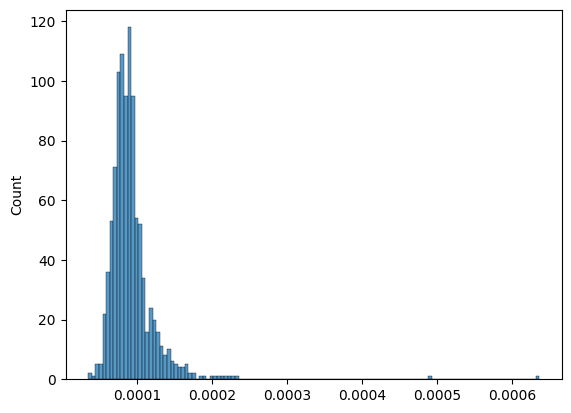

In [14]:
sns.histplot(x=valid_losses)

<Axes: ylabel='Count'>

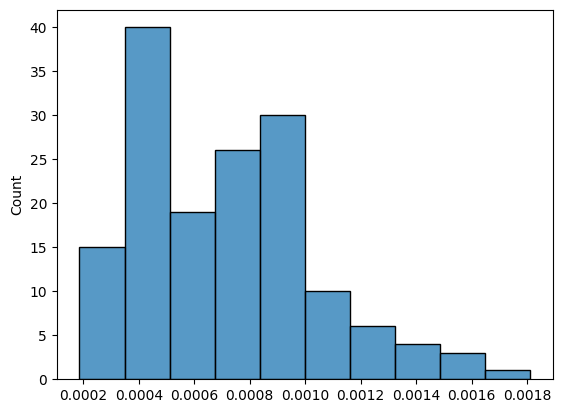

In [15]:
proliv_losses = []

for images in proliv_loader:
    current_losses = calculate_mse(images, model)
    proliv_losses.extend(current_losses)

sns.histplot(x=proliv_losses)

In [16]:
threshold = 0.00016

In [17]:
print(f"True positive rate: {np.count_nonzero(np.array(proliv_losses) > threshold) / len(proliv_losses)}")

True positive rate: 1.0


In [18]:
print(f"True negative rate: {np.count_nonzero(np.array(valid_losses) < threshold) / len(valid_losses)}")

True negative rate: 0.976


# Определяем TPR и TNR на тесте

In [19]:
threshold = 0.00016

In [21]:
test_data = TestDataset("dataset/test", "imgs", "test_annotation.txt", transform["valid"])
test_loader = DataLoader(test_data, batch_size, shuffle=True)

In [22]:
preds = []
labels = []

for batch_images, batch_labels in test_loader:
    preds += calculate_mse(batch_images, model)
    labels += batch_labels.tolist()

preds = torch.tensor(preds)
labels = torch.tensor(labels)
preds = preds > threshold

In [23]:
TP = torch.sum((preds == 1) & (labels == 1)).item()
TN = torch.sum((preds == 0) & (labels == 0)).item()
FP = torch.sum((preds == 1) & (labels == 0)).item()
FN = torch.sum((preds == 0) & (labels == 1)).item()

In [24]:
TPR = TP / (TP + FN) if (TP + FN) != 0 else 0.0

# Calculate True Negative Rate (Specificity)
TNR = TN / (TN + FP) if (TN + FP) != 0 else 0.0